In this notebook we consider the estimation of the distribution of the confusion matrix

In [1]:
import functions as f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
from algorithms import LAlgorithm
from blob_generator import BlobGenerator
import os
os.getcwd()

'c:\\Users\\coenv\\Documents\\internship\\ING\\Thesis\\code\\ModelMetricUncertaintyResearch\\mmur\\generators'

Assumed is a Gaussian distribution for both classes. Dataset consists of two Gaussian blobs, with tunable covariance between the features

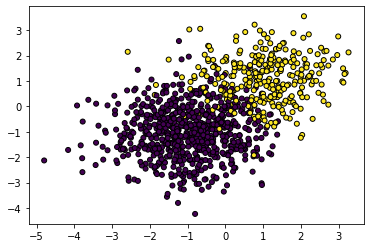

In [2]:
generator = BlobGenerator(
        train_size = 1000,
        test_size = 200,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        n_clusters_per_class=1,
        weights=[0.7,0.3],
        flip_y=0,
        class_sep=1.0,
        scale=1.0,
        shuffle=False,
        random_state=123,
        var = 1,
        cov = 0,
        random_imbalance=False)
data_dict = generator.create_train_test()

X_train = data_dict['train']['X']
y_train = data_dict['train']['y']

X_test = data_dict['test']['X']
y_test = data_dict['test']['y']

plt.scatter(X_train[:, 0], X_train[:, 1], marker="o", c=y_train[:], s=25, edgecolor="k")
del data_dict

First, we simulate the true confusion matrix distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size.
This is the same as the true distribution of the holdout estimator. From this we can also derive the true distributions of the performance metrics.

Several components are added to resemble noise present in a practical setting. 

<b>random_imbalance</b>: given the class balance set by weights, the number observations with a certain label is sampled from a binomial distribution (multinomial for n_classes>2)

<b>flip_y</b>: fraction of observations that is susceptible to being flipped. If an observation is susceptible it takes any of the labels with equal probability

<b>fix_init</b>: fixes the seed for the learning algorithm

In [3]:
def sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,fix_init,n_runs = 1000,gen_seed=123):
    generator = BlobGenerator(
        train_size,
        test_size=test_size,
        weights=weights,
        flip_y=flip_y,
        random_imbalance=random_imbalance,
        random_state=gen_seed,
        )

    LA = LAlgorithm(
        model_name,
        generator,
        fix_init=fix_init
        )

    cms = LA.sim_true_cms(n_runs)
    precs = LA.cms_to_precision(cms)
    return precs

#### 1. Simulate precision distribution with purely sampling noise (with fixed class balance) and with stochastic class balance

In [4]:
train_size = 1000
test_size = 200
weights = [0.8,0.2]
random_imbalance = False
flip_y = 0
model_name = 'LR'
fix_init = True

n_runs = 5000
random_imbalance = False
precs0 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,fix_init,n_runs = n_runs)
random_imbalance = True
precs1 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,fix_init,n_runs = n_runs,gen_seed=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 4790 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    5.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4868 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    2.8s finished


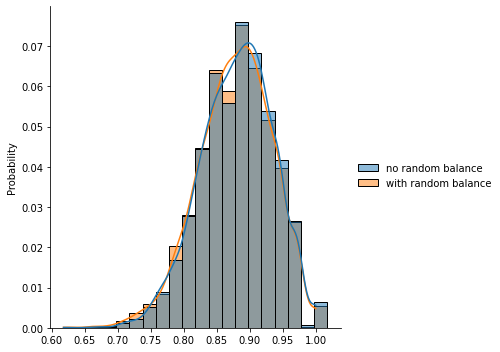

In [5]:

df = pd.DataFrame({'no random balance' : precs0, 'with random balance' : precs1})
sns.displot(df,stat = 'probability',binwidth = 0.02,kde = True)

#does not appear to make a difference for train_size=1000, perhaps for lower sample sizes? (fixed test size)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4868 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    2.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 4868 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    2.4s finished


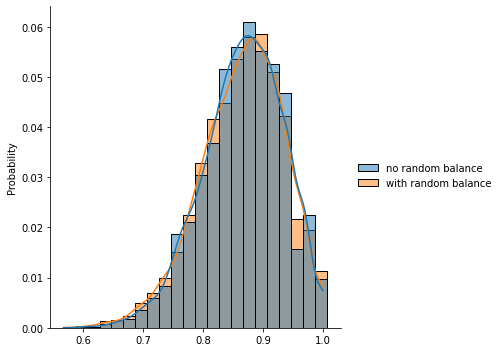

In [6]:
train_size = 100
test_size = 200
n_runs = 5000

random_imbalance = False
precs0 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,fix_init,n_runs = n_runs,gen_seed=1)
random_imbalance = True
precs1 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,fix_init,n_runs = n_runs,gen_seed=2)
n_precs = np.min([len(precs0),len(precs1)])

df = pd.DataFrame({'no random balance' : precs0[:n_precs], 'with random balance' : precs1[:n_precs]})
# sns.displot(precs0,kde=True)
# sns.displot(precs1,kde=True)
sns.displot(df,stat = 'probability',binwidth = 0.02,kde = True)

#Not really a clear difference in distribution (specifically variance) still, precisions can vary a tiny bit

#### 2. Introducing label noise to the data. What is the effect on the distribution of the precision?

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4745 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    2.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4808 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    2.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 1248 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 4868 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:    

  Flip probability    std
0                0  0.056
1          0.5*0.1  0.062
2          0.5*0.3  0.072


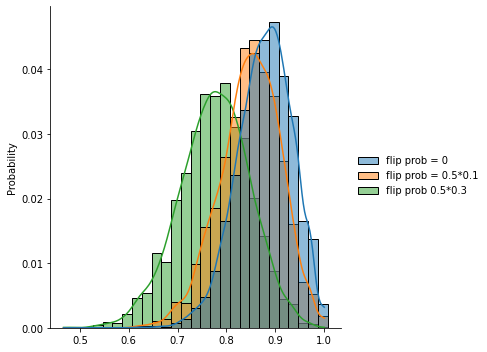

In [7]:
train_size = 1000
test_size = 200
n_runs = 5000

flip_y = 0
random_imbalance = True
precs1 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,fix_init,n_runs = n_runs,gen_seed=1)
n_precs = np.min([len(precs0),len(precs1)])

flip_y = 0.1
precs2 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,fix_init,n_runs = n_runs,gen_seed=2)
random_imbalance = True

flip_y = 0.3
precs3 = sim_precisions(train_size,test_size,weights,random_imbalance,flip_y,model_name,fix_init,n_runs = n_runs,gen_seed=3)
n_precs = np.min([len(precs1),len(precs2),len(precs3)])

df = pd.DataFrame({'flip prob = 0':precs1[:n_precs],'flip prob = 0.5*0.1' : precs2[:n_precs], 'flip prob 0.5*0.3' : precs3[:n_precs]})
sns.displot(df,stat = 'probability',binwidth = 0.02,kde = True)

#We observe that the mean precision decreases.
df = pd.DataFrame([['0','0.5*0.1','0.5*0.3'],[np.round(np.std(x),decimals=3) for x in [precs1,precs2,precs3]]]).T
df.columns = ['Flip probability','std']
print(df)

#we observe that the standard deviation of the precision increases with higher flip probability

#### 3. Consider now two models with non-deterministic training: XGBoost and a neural net (MLP), what is the distribution of the precision on a single dataset due to non-deterministic training?

In [4]:
def sim_nd_train_prec(train_size,test_size,weights,flip_y,random_imbalance,gen_seed,model_name,fix_init,n_runs,tau=0.5,parallel=False):
        generator = BlobGenerator(
                train_size,
                test_size=test_size,
                weights=weights,
                flip_y=flip_y,
                random_imbalance=random_imbalance,
                random_state=gen_seed,
                )
        LA = LAlgorithm(model_name,generator,fix_init=fix_init)
        cms = LA.repeat_nd_train(n_runs,data_seed = None,tau=tau,parallel=parallel)
        precs = LA.cms_to_precision(cms)
        return precs

c:\Users\coenv\Documents\internship\ING\Thesis\code\ModelMetricUncertaintyResearch\mmur\generators\algorithms.py:149: RuntimeWarning: invalid value encountered in true_divide
  return TP/(TP+FP)


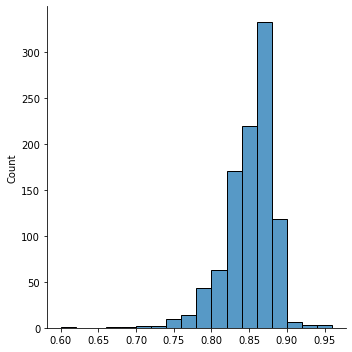

In [12]:
train_size = 1000
test_size = 200
weights = [0.8,0.2]
n_runs = 1000
flip_y = 0.1
random_imbalance = True
fix_init = False
model_name = 'NN'
gen_seed = 12

precs_NN = sim_nd_train_prec(train_size,test_size,weights,flip_y,random_imbalance,gen_seed,model_name,fix_init,n_runs,tau=0.5,parallel=True)
sns.displot(precs_NN,binwidth = 0.02)

#distribution NN performance given a fixed dataset is quite wide

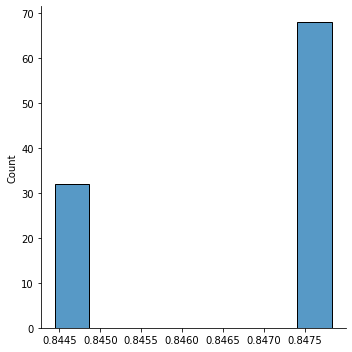

In [17]:
train_size = 1000
test_size = 200
weights = [0.8,0.2]
n_runs = 100
flip_y = 0.1
random_imbalance = True
fix_init = False
model_name = 'GB'
gen_seed = 12

precs_GB = sim_nd_train_prec(train_size,test_size,weights,flip_y,random_imbalance,gen_seed,model_name,fix_init,n_runs,tau=0.5,parallel=False)
sns.displot(precs_GB)

#minimal differences with Gradient Boosting

#### Investigating the differences in variance for a NN depending on data sample

In [14]:
def sim_var_prec_nd(train_size,test_size,weights,flip_y,random_imbalance,gen_seed,model_name,fix_init,n_runs,n_sets,tau=0.5,parallel=False):
    generator = BlobGenerator(
                train_size,
                test_size=test_size,
                weights=weights,
                flip_y=flip_y,
                random_imbalance=random_imbalance,
                random_state=gen_seed,
                )
    LA = LAlgorithm(model_name,generator,fix_init=fix_init)
    stds = LA.sim_prec_std(n_sets,n_runs,parallel=parallel)
    return stds


train_size = 1000
test_size = 200
weights = [0.8,0.2]
n_runs = 10
n_sets = 100
flip_y = 0.1
random_imbalance = True
fix_init = False
model_name = 'NN'
gen_seed = 12
stds = sim_var_prec_nd(train_size,test_size,weights,flip_y,random_imbalance,gen_seed,model_name,fix_init,n_runs,n_sets,tau=0.5,parallel=True)

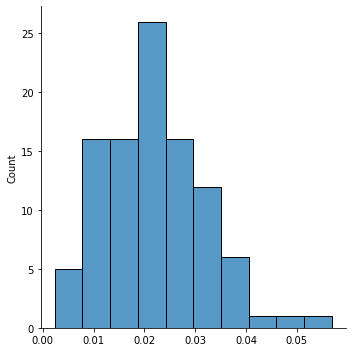

In [15]:
sns.displot(stds)

In [62]:
# # %% First we simulate the true CM distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size
# #This is the same as the true distribution of a holdout estimator
# train_size = 1000
# test_frac = 1/5
# weights = [0.8,0.2]
# n_sets = 100
# random_imbalance = False
# flip_y = 0

# model_name = 'LR'
# fix_init = True

# repeats = 10

# def simulate_cms(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,random_state,train_seed=0):
#     data_dict = f.generate_blobs(train_size = train_size,test_size=int(test_frac*train_size),n_sets=n_sets,
#                                 random_state = random_state,flip_y=flip_y,weights = weights,random_imbalance=random_imbalance)
#     return f.holdout_CM(model_name,data_dict,train_seed,fix_init=fix_init)

# cms = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

# # precisions
# TP = cms[:,1,1]
# FP = cms[:,0,1]
# precs = TP/(TP+FP)

# #recalls
# FN = cms[:,1,0]
# recs = TP/(TP+FN)

Here I experiment with different weight splits, to observe the effect on 3 models: Logistic regression, neural network and Gradient Boosting

In [144]:
# # %% First we simulate the true CM distribution, over a randomly sampled train set (of fixed size) and test set of a fixed size
# #This is the same as the true distribution of a holdout estimator

# def flatten(t):
#     return [item for sublist in t for item in sublist]

# def simulate_distr(model_names, weight_splits,train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,repeats):
#     precs_list = []
#     recs_list = []
#     col_model = []
#     col_balance = []
    
#     for model_name in model_names:
#         for w in weight_splits:
#             weights = [1-w,w]
#             cms = np.vstack(Parallel(n_jobs=-1,verbose = 1)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#                 fix_init,random_state=seed_i) for seed_i in range(repeats)))

#             # precisions
#             TP = cms[:,1,1]
#             FP = cms[:,0,1]
#             precs = TP/(TP+FP)

#             #recalls
#             FN = cms[:,1,0]
#             recs = TP/(TP+FN)
#             precs_list.append(precs.tolist())
#             recs_list.append(recs.tolist())
#             col_model.append(np.repeat(model_name,n_sets*repeats).tolist())
#             col_balance.append(np.repeat(w,n_sets*repeats).tolist())
#     results = {'precision': flatten(precs_list), 'recall':flatten(recs_list),'model':flatten(col_model),'balance':flatten(col_balance)}
#     return results

In [173]:
# model_names = ['LR','NN','GB']
# # weight_splits = [0.1,0.3,0.5]
# train_sizes = [100,200,300]

# train_size = 1000
# test_frac = 1/5
# n_sets = 10
# random_imbalance = True
# # flip_y = 0
# fix_init = True
# repeats = 1000

# for flip_y in [0.05,0.1,0.2]:

#     filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
#     plot_dir = 'c:/Users/coenv/Documents/internship/ING/Thesis/code/ModelMetricUncertaintyResearch/results'

#     results = simulate_distr(model_names, weight_splits,train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,fix_init,repeats)

#     pd.DataFrame(results).to_csv(plot_dir + filename +'.csv')

First consider only the noise introduced due to random class balance. First we fix the (mean) balance at 0.3, and set the train size at 1000. Consider a Logistic Regression model

In [61]:
# train_size = 500
# test_frac = 1/5
# weights = [0.7,0.3]
# n_sets = 1
# flip_y = 0

# model_name = 'LR'
# fix_init = True

# repeats = 1000

# random_imbalance = False
# cms0 = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

# random_imbalance = True
# cms0 = np.vstack(Parallel(n_jobs=-1,verbose = 3)(delayed(simulate_cms)(train_size,test_frac,weights,random_imbalance,n_sets,flip_y,model_name,
#     fix_init,random_state=seed_i) for seed_i in range(repeats)))

In [172]:
plot_dir = 'c:/Users/coenv/Documents/internship/ING/Thesis/code/ModelMetricUncertaintyResearch/results'

train_size = 1000
test_frac = 1/5
n_sets = 10
random_imbalance = False
flip_y = 0
fix_init = True
repeats = 1000
filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
df_0 = pd.read_csv(plot_dir + filename +'.csv')

train_size = 1000
test_frac = 1/5
n_sets = 10
random_imbalance = True #random imbalance included
flip_y = 0
fix_init = True
repeats = 1000
filename = ' '.join(['/ri',str(random_imbalance),'flip_y',str(flip_y),'fix_init',str(fix_init)])
df_1 = pd.read_csv(plot_dir + filename +'.csv')

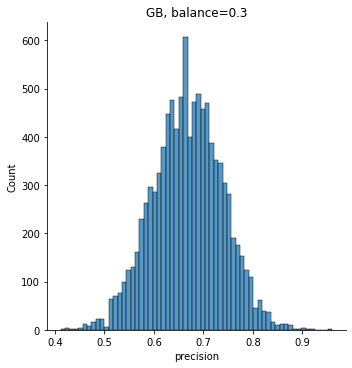

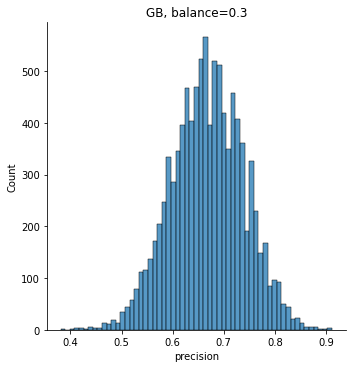

In [171]:
# # df_0 = pd.DataFrame(results)
# # sns.displot(df_0,x = 'precision',hue = 'model',col = 'balance',kde=True)
# # df_0.to_csv('results0.csv')
# # df
# def make_plot(df,model,balance,metric='precision'):
#     df_slice = df[(df['balance']==balance)& (df['model']==model)]
#     sns.displot(data=df_slice,x=metric)
#     plt.title(' '.join([model + ',','balance=' + str(balance)]))
# # sns.displot(data = df_0[(df_0['balance']==0.3)&(df_0['model']=='LR')],x = 'precision')
# # plt.title(' '.join(['LR,','balance=' + str(0.3)]))

# # make_plot(df_0,'LR',0.1,metric='recall')
# make_plot(df_0,'GB',0.3,metric='precision')
# make_plot(df_1,'GB',0.3,metric='precision')
# # make_plot(df_0,'LR',0.5,metric='recall')

In [84]:
# pd.DataFrame(np.array(precs_list).T)
# np.array(precs_list).flatten().shape
# col_model = np.repeat(model_names,repeats*n_sets*len(weight_splits)).shape
# col_balance = 
# # cms.shape

(600,)

In [6]:
# import matplotlib.cm as cm

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# H, xedges, yedges= np.histogram2d(precs,recs)



# xpos, ypos = np.meshgrid(xedges[:-1], yedges[:-1], indexing="ij")
# xpos = xpos.ravel()
# ypos = ypos.ravel()
# zpos = 0

# # Construct arrays with the dimensions for the 16 bars.
# dx = dy = 0.5 * np.ones_like(zpos)
# dz = H.ravel()

# cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
# max_height = np.max(dz)   # get range of colorbars so we can normalize
# min_height = np.min(dz)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap((k-min_height)/max_height) for k in dz] 

# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average',color = rgba)

# plt.show()

Retrieving the true precisions and recalls

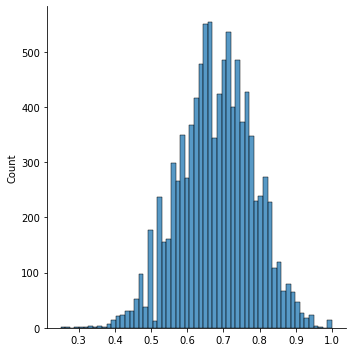

In [19]:
# # precs
# TP = cms[:,1,1]
# FP = cms[:,0,1]
# precs = TP/(TP+FP)

# #recs
# FN = cms[:,1,0]
# recs = TP/(TP+FN)

# sns.displot(precs)

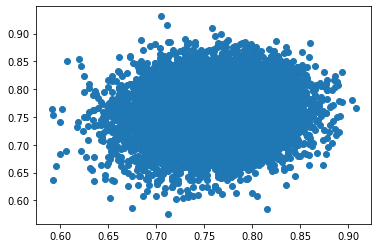

In [8]:
plt.scatter(precs,recs)

Method by Caelen (2017), multinomial likelihood with Dirichlet priors

In [28]:
#Given an observed CM, compute the distribution of a performance metric by MC-sampling
from numpy.random import default_rng

theta_prior = np.ones(4)
rng = default_rng(0)
cm = cms[0]

def sample_CM(v,theta_prior):
    theta_post = rng.dirichlet(alpha = v + theta_prior)
    cm = rng.multinomial(n = v.sum(), pvals = theta_post)
    return cm.tolist()

def sample_CM_N(v,theta_prior,MC_N=1000):
    CL_cms = np.zeros((MC_N,4),dtype = int)
    for i in range(MC_N):
        CL_cms[i] = sample_CM(v,theta_prior)
    return CL_cms

def prec_from_CMs(cms):
    TP = cms[:,-1]
    FP = cms[:,1]
    return TP/(TP+FP)

def rec_from_CMs(cms):
    TP = cms[:,-1]
    FN = cms[:,-2]
    return TP/(TP+FN)


In [37]:
cms_CA = sample_CM_N(cm.flatten(),theta_prior,MC_N=1000)
Cae_precs = []

for cm in cms[:3]:
    cms_CA = sample_CM_N(cm.flatten(),theta_prior,MC_N=1000)
    Cae_precs.append(prec_from_CMs(cms_CA))

C:\Users\coenv\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\coenv\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Distribution of precision')

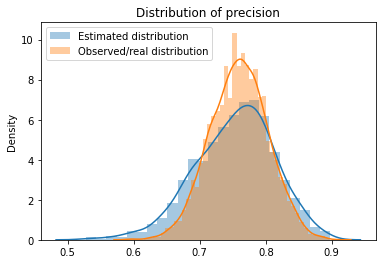

In [47]:
sns.distplot(Cae_precs[2], label = 'Estimated distribution')
sns.distplot(precs, label = 'Observed/real distribution')
plt.legend()
plt.title('Distribution of precision')

#TODO: Calculate the coverage and size of confidence intervals created by Caelen's method

In [9]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

def CM_cv(X,y,test_frac,model_name,seed=0,fix_train = False):
    kf = KFold(n_splits = int(1/test_frac)+1)
    LA = LAlgorithm(model_name)
    cms = []
    for train_index, test_index in kf.split(X):
        if not fix_train:
            seed+=1
        model = LA.init_model(random_state = seed) #initialize model
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)
        cms.append(confusion_matrix(y_test,y_pred).tolist())
    return cms

In [10]:
data_dict = f.generate_blobs(train_size = 1000,test_size=200,n_sets=n_sets,random_state = 1,flip_y=0.1)
X,y = f.unpack_data_dict(data_dict,stack = True)
cms_cv = CM_cv(X[0],y[0],test_frac,model_name)
np.array(cms_cv)

array([[[81, 19],
        [37, 63]],

       [[73, 22],
        [31, 74]],

       [[67, 32],
        [27, 74]],

       [[77, 28],
        [17, 78]],

       [[78, 35],
        [28, 59]],

       [[68, 27],
        [31, 74]]])

In [66]:
CM_cv(X_train[0],y,test_frac,seed,model_name,fix_train = False)

(1000, 1000, 2)

Firstly, consider the case where we have only a single train-test run. This is equivalent to a holdout estimator. 
To obtain a confidence interval we need to evaluate the variance of this estimator. 

This can be done by:
1.  assuming a binomial distribution on the precision/recall and using a normal approximation for the confidence interval

In [6]:
# %% To obtain a confidence interval of the expected precision we need to evaluate the variance of the holdout estimator. This can be done by assuming
#a binomial distribution and using a normal approximation for the confidence interval
n_pos = out[:,2,:].flatten()

l = true_precs - 1.96*np.sqrt((true_precs * (1-true_precs))/n_pos)
u = true_precs + 1.96*np.sqrt((true_precs * (1-true_precs))/n_pos)

#fraction of confidence intervals that cover the true population parameter value
print(np.mean((l<EP_prec) & (EP_prec<u)))

#We observe that the confidence interval is approximately correct, it covers the true mean in about 94 percent of the cases.

#Save the widths to compare with the other methods
holdout_CI_width = u-l

0.9378


2. bootstrapping both train and test

In [56]:
from numpy.random import default_rng

def bootstrap_sample(learn_algo,data_dict,seed=0,fix_init=False):
    rng = default_rng(seed)

    X_train = data_dict['train']['X']
    y_train = data_dict['train']['y']
    X_test = data_dict['test']['X']
    y_test = data_dict['test']['y']

    X = np.hstack([X_train, X_test])
    y = np.hstack([y_train, y_test])

    n_obs = y.shape[1]
    bs_indices = rng.integers(0,high = n_obs,size = y.shape)

    X_bs = np.zeros(X.shape)
    y_bs = np.zeros(y.shape)

    for i in range(len(y_bs)):
        X_bs[i] = X[i][bs_indices[i]]
        y_bs[i] = y[i][bs_indices[i]]

    train_size = y_train.shape[1]

    X_train = X_bs[:,:train_size,:]
    X_test = X_bs[:,train_size:,:]
    y_train = y_bs[:,:train_size,:]
    y_test = y_bs[:,train_size:,:]

    return X_train,X_test,y_train,y_test


def bootstrap_prec_rec(learn_algo,data_dict,seed=0,fix_init=False):
    X_train,X_test,y_train,y_test = bootstrap_sample(learn_algo,data_dict,seed=0,fix_init=False)

    if fix_init:
        train_seed = 0
    else:
        train_seed = seed
    LA = LAlgorithm(learn_algo)

    precs = []
    recs = []
    n_pos = []
    for i in range(len(y_train)):
        model = LA.init_model(random_state=train_seed+i)
        model.fit(X_train[i],y_train[i])
        y_pred = model.predict(X_test[i]) 

        n_pos.append(np.sum(y_pred==1))
        precs.append(precision_score(y_test[i],y_pred))
        recs.append(recall_score(y_test[i],y_pred))



IndentationError: expected an indented block (4180208275.py, line 39)

In [52]:


rng = default_rng(1)
n_obs = train_size + int(train_size * test_frac)
data_dict['train']['y'][0]
data_dict['train']['X']
bs_indices = rng.integers(0,high = n_obs,size = y.shape)

X = np.hstack([data_dict['train']['X'], data_dict['test']['X']])
y = np.hstack([data_dict['train']['y'], data_dict['test']['y']])

bs_indices

X_bs = np.zeros(X.shape)
y_bs = np.zeros(y.shape)

for i in range(len(y_bs)):
    X_bs[i] = X[i][bs_indices[i]]
    y_bs[i] = y[i][bs_indices[i]]


In [55]:
bs_indices[0]

array([567, 614, 906, ..., 421, 304, 461], dtype=int64)

In [34]:
data_dict['test']['X'][0].shape
np.vstack([data_dict['train']['X'][0],data_dict['test']['X'][0]]).shape


(1200, 2)

3. We can use the Bayesian method by Caelen (2017); use a Multinomial likelihood for the confusion matrix and a Dirichlet prior on the probabilities

In [15]:
cms = Parallel(n_jobs = -1,verbose = 5)(delayed(f.holdout_CM)(model_name,train_size,test_frac,n_sets=n_sets,seed=seed_i) for seed_i in range(repeats))
cms = np.vstack(cms)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   11.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.3min finished


In [ ]:
from numpy.random import multinomial


rng.dirichlet(np.ones(4))